In [1]:
# Packages
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import inception_v3
import tensorflow as tf 
from keras.applications.imagenet_utils import decode_predictions
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.linear_model import Ridge
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from tqdm.auto import tqdm
import pickle
from copy import deepcopy
from scipy.spatial import distance_matrix
import functools
import operator
from itertools import groupby
from lime.wrappers.scikit_image import SegmentationAlgorithm
from lime import lime_image
import os
import sys
import random
from sklearn import metrics
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

2024-01-27 23:22:23.647602: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-27 23:22:25.053033: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-27 23:22:25.057050: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-27 23:22:27.634130: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mchaves/LIME/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Functions

def renormalize(image):
    
    """
    Renormalizes an image to plot it (some models work with [-1,1] convention, 
    imshow wants [0,1] or 0..255).
    
    INPUT:
        - image: some image
        
    OUTPUT:
        - renormalized image
    """
    # copy of the image
    img_copy = deepcopy(image)
    
    # converting to rgb if some other convention
    input_range = np.max(img_copy) - np.min(img_copy)
    if input_range <= 1.0 and input_range >= 0.0:
        img_copy = 255.0 * img_copy
    elif input_range <= 2.0 and input_range > 1.0:
        img_copy = 127.5*(img_copy + np.ones(img_copy.shape))

    img_copy = np.uint8(img_copy)

    return img_copy

def get_replace_image (image, replace_color, norm_image, segments):
    
    """
    This function takes and image, a replacement color and segments (superpixels) related to that image, and returns the replacement image necessary for LIME. For instance if the replacement color is the mean then the replacement image consists on a each superpixels colored with the average color in the original image superpixel. 

        Inputs:
            image: a 3 channel image (can be rbg or normalized)
            replace_color: Defines the color that would replace a superpixel when it is "turned of" by the LIME algorithm. It can be a tuple of 3 numbers from 0 to 255 corresponding to rgb, "mean", "mean of pixels", "neighbors", "neighbors median", "median color", "borders" or "border superpixels". If it is a tuple it will apply an specific color, if it is "mean" it will apply the mean of the superpixel, if it is "mean of pixels" it will use the mean color for all pixels,  "neighbors" it will apply the mean color the superpixel's neighbors, "neighbors median" uses the median color among the mean color of the superpixel's neighbors, "median color" takes the median color among the mean color of the superpixels, "border" takes de median color among the colors of the pixels in the border of the image, "border superpixels" takes the median among the mean color of the superpixels in the border. 
            norm_image: Boolean. True if the image is normalized, False if it is in rgb.
            segments: superpixels derived from SegmentationAlgorithm for that specific image.            

        Outputs:
            replace_image: image necessary for LIME. For instance if the replacement color is the mean then the replacement image consists on a each superpixels colored with the average color in the original image superpixel. 
        """    
    
    # Create replacement image
    replace_image = image.copy()

    # Replacing with the mean of the superpixel
    if replace_color == "mean" or replace_color == "median color":
        for seg in np.unique(segments):
            replace_image[segments == seg] = (
                np.mean(image[segments == seg][:, 0]),
                np.mean(image[segments == seg][:, 1]),
                np.mean(image[segments == seg][:, 2]))
    
    #Replace with the mean of the image
    if replace_color == "mean of pixels":
        replace_image[:] = (
            np.mean(image[:, 0]),
            np.mean(image[:, 1]),
            np.mean(image[:, 2]))
    
    # Replacing with median color of superpixels, or median color of the border pixels, or the median color of the superpixels in the border
        
    if replace_color == "median color":        
        # Get the colors from the superpixels
        colors = []
        for seg in np.unique(segments):
            colors.append([replace_image[segments == seg][0, 0],
            replace_image[segments == seg][0, 1],
            replace_image[segments == seg][0, 2]])
    
    if replace_color == "border":
        #Get the colors from the border of the image
        colors = np.concatenate(
            [
                # Pixels in the first and last rows (second column to penultimate)
                [list(j) for i in image[[0,-1],1:-1] for j in i] , 
                # Pixels in the first and last columns
                [list(j) for i in image[:,[0,-1]] for j in i]
            ]   
        )
    
    if replace_color == "border superpixels":
        # Matrix identifying the borders
        border_matrix = np.zeros([input_shape, input_shape])
        border_matrix[[0,-1]] = 1
        border_matrix[:,[0,-1]] = 1
        # Get the superpixels that are in the border
        superpix_border = np.unique((segments + 1) * border_matrix) - 1
        superpix_border = superpix_border[1:]
        # Get the mean color of each superpixels in the border
        colors = []
        for sup in superpix_border:
            colors.append((
                np.mean(image[segments == sup][:, 0]),
                np.mean(image[segments == sup][:, 1]),
                np.mean(image[segments == sup][:, 2])))
        colors = np.uint8(colors)

    if replace_color == "median color" or replace_color == "border" or replace_color == "border superpixels":
        # Distance matrix
        dist_matrix = distance_matrix(colors, colors)
        # Sum by rows and get the argmin
        color_position = np.argmin(np.sum(dist_matrix, axis = 0))
        # Replace with the color with the minimal distances
        replace_image[:] = tuple(colors[color_position])


    # Replacing with the mean or median color of its neighbors superpixels
    if replace_color == "neighbors" or "neighbors median":
        kernel = np.ones((3, 3), 'uint8')
        for seg in np.unique(segments):
            # Binary matrix identifying a superpixel
            superpix = (segments == seg).astype(np.uint8)
            # Dilate the superpixel
            dilate_img = cv2.dilate(superpix, kernel, iterations=1)
            # Take the outer edge of the superpixel
            border_superpix = dilate_img-superpix 
            # Identify the neighbors of the segment
            neighbors = np.array([i for i in np.unique(border_superpix * (segments+1)) if i !=0]) - 1
            
            if replace_color == "neighbors":
                # Create a boolean matrix to identify the pixels that belong to the neighbors
                neighbors_matrix = np.zeros(input_shape*input_shape,  dtype=bool).reshape(input_shape,input_shape)
                for nei in neighbors:
                    neighbors_matrix += (segments == nei)
                # Use the mean color of the neighbors to color the superpixel
                replace_image[segments == seg] = (
                    np.mean(image[neighbors_matrix][:, 0]),
                    np.mean(image[neighbors_matrix][:, 1]),
                    np.mean(image[neighbors_matrix][:, 2]))
            
            if replace_color == "neighbors median":    
                # Get the mean color for each neighbor superpixel
                colors = []
                for nei in neighbors:
                    colors.append((
                        np.mean(image[segments == nei][:, 0]),
                        np.mean(image[segments == nei][:, 1]),
                        np.mean(image[segments == nei][:, 2])))
                colors = np.uint8(colors)
                # Distance matrix of the colors
                dist_matrix = distance_matrix(colors, colors)
                # Sum by rows and get the argmin
                color_position = np.argmin(np.sum(dist_matrix, axis = 0))
                # Use the median color of the neighbors to color the superpixel
                replace_image[segments == seg] = colors[color_position]

    # Replacing with a specific color
    if len(replace_color) == 3:
        #Normalize hiden color if necesary 
        if norm_image:
            replace_color = tuple(2*i/255-1 for i in replace_color)
        #Replace with the specific color
        replace_image[:] = replace_color

    return replace_image

def get_border_superpixels(image, segments):

    """
    This function takes and image, and segments (superpixels) related to that image, and returns the image with the superpixels's borders. 

        Inputs:
            image: a 3 channel image (can be rbg or normalized)
            segments: superpixels derived from SegmentationAlgorithm for that specific image.            

        Outputs:
            borders_image: the input image adding the borders of the superpixels. 
        """    

    border = np.zeros(image.shape[0]*image.shape[1],  dtype=bool).reshape(image.shape[0], image.shape[1])
    kernel = np.ones((3, 3), 'uint8')
    for seg in np.unique(segments):
        superpix = (segments == seg).astype(np.uint8)
        border += np.array(cv2.morphologyEx(superpix, cv2.MORPH_GRADIENT, kernel), dtype = bool)
    borders_image = image.copy()
    borders_image[border] = (0,255,0)

    return borders_image


def get_image_explanation (image, top, coefs_tuples, segments):

    """
    This function produces an image with the most important superpixels (according to LIME) colored in green.  

        Inputs:
            image: a 3 channel image (can be rbg or normalized)
            top: the number of top superpixels that we want to highlight.
            coef_tuples: a list of tuples which contain the superpixel number and the coefficient for that superpixel.
            segments: superpixels derived from SegmentationAlgorithm for that specific image.            

        Outputs:
            replace_image: image necessary for LIME. For instance if the replacement color is the mean then the replacement image consists on a each superpixels colored with the average color in the original image superpixel. 
        """    

    # Get the top n superpixels
    top_seg_coef = [c for c in coefs_tuples if c[1]>0][0:top] 
    pos_ids = [i[0] for i in top_seg_coef] 

    # Define the image
    height,width,_ = image.shape
    out_size = height #this is the resolution
    image_copy = renormalize(image) #transform to rgb 
    resized_image = np.uint8(tf.image.resize(image_copy,size=(out_size-2,out_size-1)))
    x = np.linspace(0,width, out_size)
    y = np.linspace(0,height, out_size)
    X, Y = np.meshgrid(x[:-1],y[:-1])
    convert = lambda x,y: segments[int(y),int(x)]
    vec_convert = np.vectorize(convert)
    resized_segments = vec_convert(X[:-1],Y[:-1])

    for idx in pos_ids:
        resized_image[resized_segments == idx] = (0,128,0)

    return resized_image

    
def get_image_coef_heatmap (image, coefs_tuples, segments):

    """
    This function produces an heatmap of the superpixels according to their coeficients obtain from the LIME resuts.  

        Inputs:
            image: a 3 channel image (can be rbg or normalized)
            coef_tuples: a list of tuples which contain the superpixel number and the coefficient for that superpixel.
            segments: superpixels derived from SegmentationAlgorithm for that specific image.            

        Outputs:
            image_coeficients: image in a heatmap-like format, the superpixels assume the value of their respective coefficient. 
        """    

    image_coeficients = np.zeros([image.shape[0],image.shape[1]])

    for seg, coef in coefs_tuples:
        image_coeficients[segments == seg] = (coef)
    
    return image_coeficients

def jaccard_index(coefs1, coefs2, top):

    """
    This function calculates the jaccard index for the most important superpixels of two different LIME results.  

        Inputs:
            top: the number of top superpixels that we want to highlight.
            coefs1, coefs2: a list of tuples which contain the superpixel number and the coefficient for that superpixel.

        Outputs:
            jaccard_index: ratio of the intersection over the union of the most important coeficients. 
        """    

    superpix1 = set([i[0] for i in coefs1 if i[1]>0][0:top])  
    superpix2 = set([i[0] for i in coefs2 if i[1]>0][0:top])
    
    return len(set.intersection(superpix1,superpix2)) / len(set.union(superpix1,superpix2))

def euclidean_dist_coefs_norm(coefs1, coefs2):

    """
    This function calculates the euclidean distance between the coeficients of the surogate model of two LIME results and divides by the norm of the coefficients in coeffs1.  

        Inputs:
            coefs1, coefs2: a list of tuples which contain the superpixel number and the coefficient for that superpixel.

        Outputs:
            euclidean_distance between the coefficients. 
    """    

    # coeficients ordered by superpixel 
    order_coefs1 = np.array(sorted(coefs1, key=lambda x: x[0]))[:,1] 
    order_coefs2 = np.array(sorted(coefs2, key=lambda x: x[0]))[:,1]
    # euclidean distance 
    return np.linalg.norm(order_coefs1-order_coefs2)/np.linalg.norm(order_coefs1)

def delta_prob(image, top, coefs_tuples , segments, preds , replace_color , top_class):

    """
    This function replaces the top superpixels by their counterparts in the a replacement image. We use this new image in the classifier an observe the drop (absolute and percentualy) in the prediction's probability.

        Inputs:
            image: a 3 channel image (rbg format)
            top: the number of top superpixels that we want to highlight.
            coef_tuples: a list of tuples which contain the superpixel number and the coefficient for that superpixel.
            segments: superpixels derived from SegmentationAlgorithm for that specific image.
            preds: the vector containing the probabilities of belonging to each class (according to the classifier) in the original image
            replace_color: Defines the color that would replace a superpixel when it is "turned off" by the LIME algorithm. It can be a tuple of 3 numbers from 0 to 255 corresponding to rgb, "mean", "mean of pixels", "neighbors", "neighbors median", "median color", "borders" or "border superpixels". If it is a tuple it will apply an specific color, if it is "mean" it will apply the mean of the superpixel, if it is "mean of pixels" it will use the mean color for all pixels,  "neighbors" it will apply the mean color the superpixel's neighbors, "neighbors median" uses the median color among the mean color of the superpixel's neighbors, "median color" takes the median color among the mean color of the superpixels, "border" takes de median color among the colors of the pixels in the border of the image, "border superpixels" takes the median among the mean color of the superpixels in the border. 
            top_class: the class that the classifier predicted
        
        Output:
            absolute_delta : the probability of belonging to the top_class in the modified image minus the probability of belonging to the top_class in the original image
            percent_delta: The percent of change between the two probabilities
            new_image: the modified image 
    """


    # Get the top n superpixels
    top_seg_coef = [c for c in coefs_tuples if c[1]>0][0:top] 
    top_superpix = [i[0] for i in top_seg_coef] 

    # Get replacement image
    replace_image = get_replace_image(image = image, replace_color = replace_color, norm_image = False, segments = segments)

    # Replace the top superpixels for their counterparts in the replacement image
    new_image = image.copy()
    for s in top_superpix: 
        new_image[ segments == s ] = replace_image[ segments == s ]

    # Get the prediction (in the same category) for the new image
    xi_norm = preprocess_fn(new_image)
    preds_new = model_inceptionv3.predict(tf.expand_dims(xi_norm,0))

    # Drop in the probability of belonging to the original class
    absolute_delta = preds_new[0][top_class] - preds[0][top_class]
    percent_delta = (preds_new[0][top_class] - preds[0][top_class]) / preds[0][top_class] * 100

    return { 'absolute_delta': absolute_delta, 'percent_delta': percent_delta, 'new_image': new_image }

def deletion_metric(image, top, coefs_tuples, segments, preds, replace_color, top_class):

  """
    This function gets the deletion metric.

        Inputs:
            image: a 3 channel image (rbg format)
            top: the number of top superpixels that we want to highlight.
            coef_tuples: a list of tuples which contain the superpixel number and the coefficient for that superpixel.
            segments: superpixels derived from SegmentationAlgorithm for that specific image.
            preds: the vector containing the probabilities of belonging to each class (according to the classifier) in the original image
            replace_color: Defines the color that would replace a superpixel when it is "turned off" by the LIME algorithm. It can be a tuple of 3 numbers from 0 to 255 corresponding to rgb, "mean", "mean of pixels", "neighbors", "neighbors median", "median color", "borders", "border superpixels", or "inpainting". If it is a tuple it will apply an specific color, if it is "mean" it will apply the mean of the superpixel, if it is "mean of pixels" it will use the mean color for all pixels,  "neighbors" it will apply the mean color the superpixel's neighbors, "neighbors median" uses the median color among the mean color of the superpixel's neighbors, "median color" takes the median color among the mean color of the superpixels, "border" takes de median color among the colors of the pixels in the border of the image, "border superpixels" takes the median among the mean color of the superpixels in the border, "inpainting" uses an inpainting algorithm to replace the top superpixels. 
            top_class: the class that the classifier predicted
        
        Output:
            deletion metric
            new_image: the modified image 

        Important: 
            Inpainting option would not work without a the DeepGIN modified repo and a GPU
    """

  # Get the top n superpixels
  top_seg_coef = [c for c in coefs_tuples if c[1]>0][0:top] 
  top_superpix = [i[0] for i in top_seg_coef] 

  # Get replacement image 
  if replace_color == "inpainting":
    replace_image = get_replace_image(image = image, replace_color = (255,255,255), norm_image = False, segments = segments)
  else:
    replace_image = get_replace_image(image = image, replace_color = replace_color, norm_image = False, segments = segments)

  # Generate images where we increasingly change the superpixels by the ones in the replacement image
  # We start substituting in order of importance
  new_images = []
  for i in range(len(top_superpix)+1)[1:]: 
      temp_top_superpix = top_superpix[0:i] 
      new_image = image.copy()
      for s in temp_top_superpix: 
          new_image[ segments == s ] = replace_image[ segments == s ]
      if replace_color == "inpainting":
          new_image = Image.fromarray(new_image.astype('uint8'), 'RGB')
      new_images.append(new_image)
  if replace_color != "inpainting":
      new_images = np.array(new_images)

  # If the replace method is inpaint, inpaint the superpixels that were replaced in the previous step
  if replace_color == 'inpainting':
      # Create masks
      masks = []
      for i in range(len(top_superpix)+1)[1:]: 
          temp_top_superpix = top_superpix[0:i]
          mask = np.zeros(segments.shape)
          for s in temp_top_superpix:
              mask[ segments == s ] = 255
          mask = Image.fromarray(mask.astype('uint8'), 'L')
          masks.append(mask)

      # Save new image and mask to be used by the inpainting model
      pickle_name = 'results/test/images_and_masks_deletion_metric.pkl'
      with open(pickle_name,'wb') as f:
          pickle.dump(list(zip(new_images,masks)),f)
      # Use the inpainting model
      os.system('python inpainting_images.py --name gin --input_pkl results/test/images_and_masks_deletion_metric.pkl --output_pkl results/test/inpaint_new_images_deletion_metric.pkl')
      # Load result of the inpainting model
      pickle_name = 'results/test/inpaint_new_images_deletion_metric.pkl'
      with open(pickle_name, 'rb') as f:
          new_images = pickle.load(f)
      new_images = np.uint8(np.array(new_images))

  # Get the prediction (in the same category) for the new image
  xi_norms = preprocess_fn(new_images)
  preds_new = model_inceptionv3.predict(np.array(xi_norms))

  # Probabilities in the original image and the new images to belong to the top class 
  probs = np.insert(preds_new[:,top_class], 0, preds[0][top_class])

  # Area under the curve of the probabilities
  deletion_metric = metrics.auc(range(len(probs)), probs)

  return { 'deletion_metric': deletion_metric, 'new_images': new_images }

def encode_segments (segments):
    
    """
    This function encodes the segments to reduce their space in storage.

    Inputs:
        Segments: superpixels derived from SegmentationAlgorithm for that specific image.
    Output:
        The vector of encoding
    """

    # Change type to integer 16
    segments = segments.astype('int16')
    # Segments to vectos
    encoded_segments = functools.reduce(operator.iconcat, segments, [])
    # Pairs where:
    # first element of the pair indicates the superpixel number
    # second element of the pair indicates the times it must be repeated
    encoded_segments = [[k,len(list(v))] for k,v in groupby(encoded_segments)]
    # Pairs to vector
    encoded_segments = functools.reduce(operator.iconcat, encoded_segments, [])

    return encoded_segments

def decode_segments(encoded_segments, input_shape = 299):
    """
    This fucntions decodes the enconded segments
    
    Input:
        encoded_segments: vector of encoded vectors
        input_shape: the original shape of the segments

    Output: 
        segments

    """

    # get pairs of superpixel and its repetitions
    decoded_segments = np.reshape(encoded_segments, (int(len(encoded_segments)/2),2))
    # repeat the superpixels the necesary times
    decoded_segments = [np.repeat(i,j) for i,j in decoded_segments]
    # reduce the list of lists to a list
    decoded_segments = functools.reduce(operator.iconcat, decoded_segments, [])
    # give the shape of the original segments
    decoded_segments = np.reshape(decoded_segments, (input_shape, input_shape))

    return decoded_segments

def preprocess_fn(image):
  """
    This function defines the preprocessing of the image required to use the classifier (inception v3)
    
    Input:
        image: rgb image in the format of a np array type uint8

    Output: 
        An image in the preprocessed format

    """
  return inception_v3.preprocess_input(image.copy()).astype('double')

def lime_for_image (image, classifier_fn, replace_color, norm_image, num_samples, random_seed = 0, segmenter = None, encode_seg = False, top = 1, classes = None): 
    """
    This function takes and image and a classifier and applies the LIME algorithm

        Inputs:
            image: a 3 channel image (can be rbg or normalized)
            classifier_fn: classifier prediction probability function, which takes a numpy array and outputs prediction probabilities.  For ScikitClassifiers , this is classifier.predict_proba.
            replace_color: Defines the color that would replace a superpixel when it is "turned off" by the LIME algorithm. It can be a tuple of 3 numbers from 0 to 255 corresponding to rgb, "mean", "mean of pixels", "neighbors", "neighbors median", "median color", "borders", "border superpixels", or "inpainting". If it is a tuple it will apply an specific color, if it is "mean" it will apply the mean of the superpixel, if it is "mean of pixels" it will use the mean color for all pixels,  "neighbors" it will apply the mean color the superpixel's neighbors, "neighbors median" uses the median color among the mean color of the superpixel's neighbors, "median color" takes the median color among the mean color of the superpixels, "border" takes de median color among the colors of the pixels in the border of the image, "border superpixels" takes the median among the mean color of the superpixels in the border, 
            norm_image: Boolean. True if the image is normalized, False if it is in rgb.
            num_samples: number perturbated images to generate.
            random_seed: integer used as random seed.
            segmenter: if None, then it uses 'quickshift' algorithm  with kernel size  = 4, maximum distance = 200 and ratio = 0.2 by default. A segmenter can be specified.
            encode_seg: Boolean, if True, the output will include the segments in a encoded format, if False, it will return the segments in its usual format
            top: the number of top classes, defaults to 1. If we want to use specific classes then use top = None
            classes: here we can specifiy specific classes to use. It must be given as a list. For example, classes = [36,95,999], or classes = [46] if we want to use just one class. If we don't want to specifiy the classes, then classes = None. 

        Outputs: A dictionary with:
            segments: superpixels derived from SegmentationAlgorithm for that specific image (either encoded or not).  
            results: a list of dictionaries, corresponding to the results of each of the top classes. This dictionaries include:
                top class: the class selected
                intercept: intercept of the surrogate model generated by LIME
                coefs: tuples of superpixels number and its associated coefficient
                score: r squared
                prediction: prediction from the surrogate model 
        """

    # Superpixels
    # If no segmenter was specified use the default one 
    if segmenter == None:
        segmenter = SegmentationAlgorithm('quickshift', kernel_size=4,max_dist=200, ratio=0.2, random_seed=random_seed)
    segments = segmenter(image)

    #Get replacement image
    replace_image = get_replace_image(image = image, replace_color = replace_color, norm_image = norm_image, segments = segments)

    # Define the list of of z_i 
    n_features = np.unique(segments).shape[0]
    np.random.seed(random_seed)
    data = np.random.binomial(n=1, p=0.5, size=num_samples * n_features).reshape((num_samples, n_features))
    # Define z_1 as the original, i.e., a vector of 1s
    data[0, :] = 1

    # Defining empty lists for the new objects
    labels = []
    imgs = []

    # Get modified images
    for row in data:
        temp = image.copy()
        zeros = np.where(row == 0)[0]
        mask = np.zeros(segments.shape).astype(bool)
        for z in zeros:
            mask[segments == z] = True
        temp[mask] = replace_image[mask]
        imgs.append(temp)

    #Make predictions over the modified images
    preds = classifier_fn(np.array(imgs))
    labels.extend(preds)
    labels = np.array(labels) 

    # Top classes selected by the classifier or the classes we want to evaluate
    if classes == None :
        top_classes = np.argsort(labels[0])[-top:][::-1]
    else :
        top_classes = classes

    # Weights 
    distances = pairwise_distances(
        data,
        data[0].reshape(1, -1),
        metric = "cosine"
    ).ravel()
    weights = np.sqrt(np.exp(-(distances ** 2) / 0.25 ** 2))

    # Surrogate model for each top class
    results = []
    for top_class in top_classes:
        # Predictions for the class
        labels_column = labels[:, top_class]
        # Ridge model
        surrogate_model = Ridge(alpha = 1, 
                                fit_intercept = True, 
                                random_state = random_seed)
        surrogate_model.fit(data, labels_column, sample_weight = weights)

        #save results
        intercepts = surrogate_model.intercept_
        coefs = sorted(zip(np.unique(segments), surrogate_model.coef_), key=lambda x: np.abs(x[1]), reverse=True)
        scores = surrogate_model.score(data, labels_column, sample_weight=weights)
        predictions = surrogate_model.predict(data[0].reshape(1, -1))[0]
        results.append({'top class': top_class, 'intercept': intercepts, 'coefs': coefs, 'score': scores, 'prediction': predictions})

    # Encode segments if required
    if encode_seg :
        segments = encode_segments(segments = segments)

    return {'segments': segments, 'results': results }

In [5]:
# List of images where default LIME fails
images_LIME_failed = [13, 28, 297, 1556, 1650, 2322, 2503, 2568, 2701, 3447, 5235, 5288]

# Coordinates of the selected color in the replacement image (using mean replacement)
color_coordinates = [[275,250],[100,175],[175,100],[100,150],[100,250],[250,100],[150,200],[100,175],[225,150],[75,150],[200,150],[75,225]]

# Image shape
input_shape = 299

# Image path
data_path = 'img/'

# Setting model
# model = inception_v3.InceptionV3(weights='imagenet')
# model_inceptionv3 = inception_v3.InceptionV3(weights='imagenet')
# Preprocessing
preprocess = inception_v3.preprocess_input

# Technique names
# names = ["Default LIME", "Manual color", "Mean of the pixels", "Mean of the \n superpixel's neighbors", "Median among the mean \n of the superpixels", "Median of the \n border's pixels", "Median among the mean \n of the border's \n superpixels", "Median among the mean \n of the superpixel's \n neighbors"]

In [6]:
# Get replacement manual color

counter = 0
manual_color = []

for i in images_LIME_failed:

    # Image number and shape
    id_image = i

    # Path
    image_name = 'ILSVRC2017_test_' + str(id_image).zfill(8) 
    image_path = data_path + image_name + '.JPEG'

    # Loading and converting the image
    xi_orig = load_img(image_path, target_size=(input_shape, input_shape))
    xi_rgb  = img_to_array(xi_orig)
    xi_norm = preprocess(xi_rgb.copy()).astype('double')

    # Superpixel segmentation (we take big superpixels this time to better ilustrate)
    segmenter = SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2, random_seed=32)
    segments = segmenter(xi_norm)

    # Convert rgb image to numpy
    xi_rgb  = np.uint8(img_to_array(xi_orig))

    #Replacement with neighbors
    replace_image = get_replace_image(xi_rgb, replace_color="mean", norm_image=False, segments=segments)

    # Manual replacement color
    replace_color = tuple(replace_image[color_coordinates[counter][1], color_coordinates[counter][0]])
    manual_color.append(replace_color)

    counter += 1

# Apply LIME with different perturbed samples generation methods. 

In [7]:
# Selected index of one of the images
selected_id = 6

# Technique names
names = ["Default LIME", "Manual color", "Mean of the pixels", "Mean of the \n superpixel's neighbors", "Median among the mean \n of the superpixels", "Median of the \n border's pixels", "Median among the \n mean of the border's \n superpixels", "Median among the mean \n of the superpixel's \n neighbors"]
# Replacement
replace_colors = ["mean", manual_color[selected_id], "mean of pixels", "neighbors", "median color", "border", "border superpixels", "neighbors median"]


# Load original image
id_image = images_LIME_failed[selected_id]
image_name = 'ILSVRC2017_test_' + str(id_image).zfill(8) 
image_path = data_path + image_name + '.JPEG'
# Transformations of the image
xi_orig = load_img(image_path, target_size=(input_shape, input_shape))
xi_rgb  = img_to_array(xi_orig)
xi_norm = preprocess_fn(xi_rgb)
# Define the classifier model and get predictions
model = inception_v3.InceptionV3(weights='imagenet')
preds = model.predict(tf.expand_dims(xi_norm,0))
label_predicted = decode_predictions(preds, top=1)[0][0][1]
# Transformations of the image
xi_rgb  = np.uint8(img_to_array(xi_orig))

lime_results = []

# Apply LIME with different replacements
for replacement in replace_colors:

    results = lime_for_image(image = xi_norm, 
                    classifier_fn = model.predict, 
                    replace_color = replacement, 
                    norm_image = "True", 
                    num_samples = 1000, 
                    random_seed = 32)
    lime_results.append(results)

2024-01-27 23:23:35.837369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-27 23:23:35.838453: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


32/32 [==============================] - 148s 5s/step


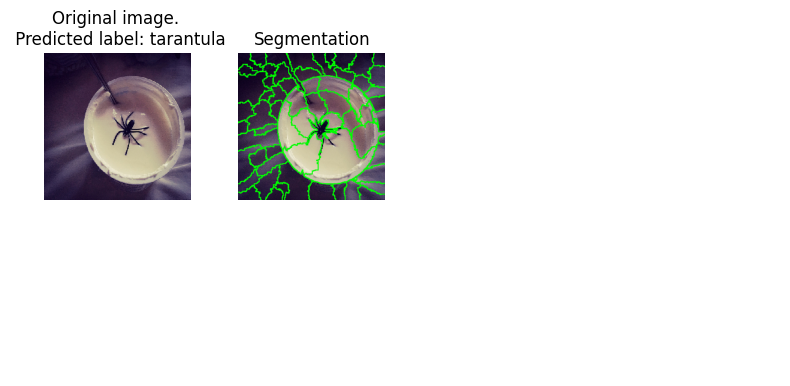

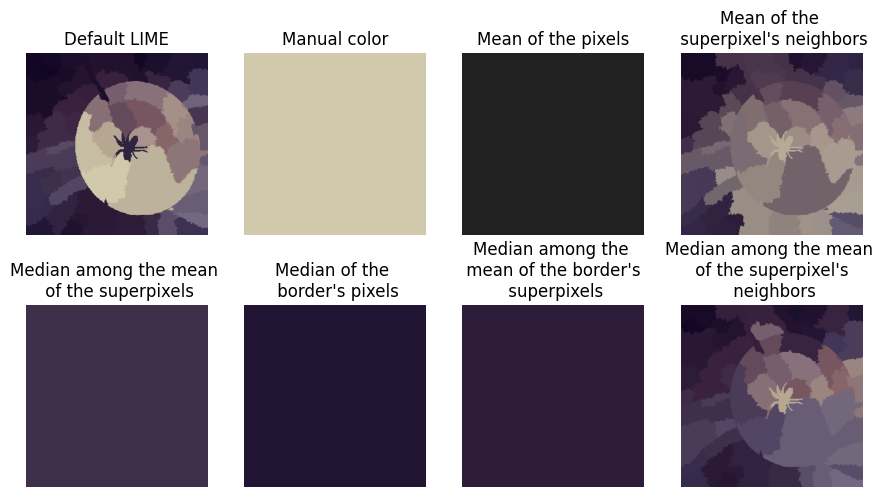

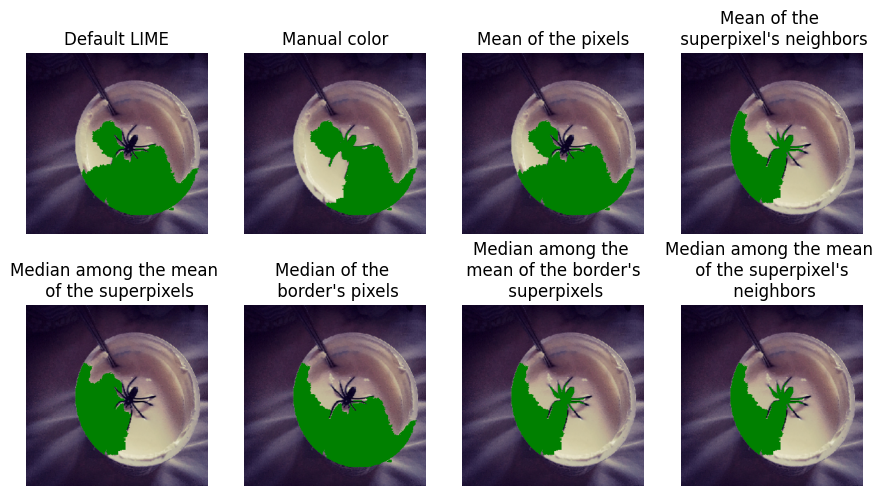

In [9]:
# Original image and segmentation
n_cols = 4
n_rows = 2
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=False, sharey=False, figsize=(n_cols*2.4, n_rows*2.1))
axes = axes.ravel()
# Do not show axis
# [axi.set_axis_off() for axi in axes.ravel()]
[axi.set_yticklabels([]) for axi in axes.ravel()]
[axi.set_xticklabels([]) for axi in axes.ravel()]
[axi.set_yticks([]) for axi in axes.ravel()]
[axi.set_xticks([]) for axi in axes.ravel()]
[axi.spines["top"].set_visible(False) for axi in axes.ravel()]
[axi.spines["bottom"].set_visible(False) for axi in axes.ravel()]
[axi.spines["left"].set_visible(False) for axi in axes.ravel()]
[axi.spines["right"].set_visible(False) for axi in axes.ravel()]

# Original image
axes[0].imshow(xi_rgb)
axes[0].set_title('Original image. \n Predicted label: '+label_predicted)

# Segmentation
axes[1].imshow(get_border_superpixels(image = xi_rgb, segments = lime_results[0]['segments']))
axes[1].set_title('Segmentation')

plt.savefig("results/original_image_and_segmentation"+str(id_image)+".pdf", bbox_inches = 'tight')

# Replacement images
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=False, sharey=False, figsize=(n_cols*2.7, n_rows*3))
axes = axes.ravel()
# Do not show axis
# [axi.set_axis_off() for axi in axes.ravel()]
[axi.set_yticklabels([]) for axi in axes.ravel()]
[axi.set_xticklabels([]) for axi in axes.ravel()]
[axi.set_yticks([]) for axi in axes.ravel()]
[axi.set_xticks([]) for axi in axes.ravel()]
[axi.spines["top"].set_visible(False) for axi in axes.ravel()]
[axi.spines["bottom"].set_visible(False) for axi in axes.ravel()]
[axi.spines["left"].set_visible(False) for axi in axes.ravel()]
[axi.spines["right"].set_visible(False) for axi in axes.ravel()]

# Replacement image and explanation
for j in range(len(names)):
    if names[j] == "LIME-G":
        pass

    else :
        #Replacement image
        replacement_image = get_replace_image(image = xi_rgb, replace_color = replace_colors[j], norm_image = False, segments = lime_results[j]['segments'])
        axes[j].imshow(replacement_image)
    
        # Add titles
        axes[j].set_title(names[j])

plt.savefig("results/replacement_images"+str(id_image)+".pdf", bbox_inches = 'tight')

# Explanations

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=False, sharey=False, figsize=(n_cols*2.7, n_rows*3))
axes = axes.ravel()
# Do not show axis
# [axi.set_axis_off() for axi in axes.ravel()]
[axi.set_yticklabels([]) for axi in axes.ravel()]
[axi.set_xticklabels([]) for axi in axes.ravel()]
[axi.set_yticks([]) for axi in axes.ravel()]
[axi.set_xticks([]) for axi in axes.ravel()]
[axi.spines["top"].set_visible(False) for axi in axes.ravel()]
[axi.spines["bottom"].set_visible(False) for axi in axes.ravel()]
[axi.spines["left"].set_visible(False) for axi in axes.ravel()]
[axi.spines["right"].set_visible(False) for axi in axes.ravel()]

# Replacement image and explanation
for j in range(len(names)):
    
    #Image with explanations
    image_explanation = get_image_explanation(image = xi_norm, top = 3, coefs_tuples = lime_results[j]['results'][0]['coefs'], segments = lime_results[j]['segments'])
    axes[j].imshow(image_explanation)
    
    # Add titles
    axes[j].set_title(names[j])

plt.savefig("results/lime_results"+str(id_image)+".pdf", bbox_inches = 'tight')